# CS3244 Project Neural Networks

This file will contain the code for the neural network model that is being used for our project. In this code, we will be approaching it using a two types of models:

1. MLP
2. RNN (LSTM)

We will follow this breakdown of sequencing in how we approach the problem using neural networks.

## Importing datasets and packages

We will begin with importing all relevant datasets and packages needed in order to create our model.

### Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score

import optuna
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### Importing datasets

#### MLP datasets

In [2]:
fold1 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/fold_1.csv')
fold2 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/fold_2.csv')
fold3 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/fold_3.csv')
fold4 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/fold_4.csv')
fold5 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/fold_5.csv')

smote_fold_1 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/smote_train_data/smote_fold_5.csv')

In [3]:
test_df = pd.read_csv('/Users/Berniss/Downloads/CS3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/finalised_datasets/transformed_data/test_set.csv')

X_test = test_df.drop(columns=['fraud_status'])
y_test = test_df['fraud_status']

#### RNN datasets

In [4]:
#invoice = pd.read_csv('cleaned_invoice_train.csv')
#client = pd.read_csv('cleaned_client_train.csv')

## MLP model

The MLP model is a simple feed-forward neural network model. It will use the universally used aggregated dataset that we have used for all other models. We have decided to use an MLP model as it is the best neural network model when it comes to working with our aggregated dataset. This is because RNNs work with sequential data, which the aggregated dataset does not have, and CNN works best for matrix data (images), which again we do not have.

We will proceed with this flow:
1. Feature engineering for MLP
2. Model MLP
3. Evaluate MLP

### Feature Engineering for MLP

We will begin with feature engineering that is specific to the MLP model. This is because neural networks require specific altercations to the data for it to function effectively.

In [5]:
X_smoted_1 = smote_fold_1.drop(columns='fraud_status')
y_smoted_1 = smote_fold_1['fraud_status']
X_smoted_2 = smote_fold_2.drop(columns='fraud_status')
y_smoted_2 = smote_fold_2['fraud_status']
X_smoted_3 = smote_fold_3.drop(columns='fraud_status')
y_smoted_3 = smote_fold_3['fraud_status']
X_smoted_4 = smote_fold_4.drop(columns='fraud_status')
y_smoted_4 = smote_fold_4['fraud_status']
X_smoted_5 = smote_fold_5.drop(columns='fraud_status')
y_smoted_5 = smote_fold_5['fraud_status']
smoted_folds = [(X_smoted_1, y_smoted_1), (X_smoted_2, y_smoted_2), (X_smoted_3, y_smoted_3), (X_smoted_4, y_smoted_4), (X_smoted_5, y_smoted_5)]

X_fold_1 = fold1.drop(columns='fraud_status')
y_fold_1 = fold1['fraud_status']
X_fold_2 = fold2.drop(columns='fraud_status')
y_fold_2 = fold2['fraud_status']
X_fold_3 = fold3.drop(columns='fraud_status')
y_fold_3 = fold3['fraud_status']
X_fold_4 = fold4.drop(columns='fraud_status')
y_fold_4 = fold4['fraud_status']
X_fold_5 = fold5.drop(columns='fraud_status')
y_fold_5 = fold5['fraud_status']
folds = [(X_fold_1, y_fold_1), (X_fold_2, y_fold_2), (X_fold_3, y_fold_3), (X_fold_4, y_fold_4), (X_fold_5, y_fold_5)]

In [6]:
scaler = StandardScaler()

# Fit the scaler on the entire training data (folds[0][0])
scaler.fit(folds[0][0])

# Modify the sample_fold function to scale the input data
def sample_fold(X, y, sample_fraction=0.1):
    sample_size = int(len(X) * sample_fraction)
    sample_indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = scaler.transform(X.iloc[sample_indices])  # Scale X_sample
    return pd.DataFrame(X_sample, columns=X.columns), y.iloc[sample_indices]

# Take 50% samples of each original and SMOTEd fold (and apply scaling)
sampled_folds = [sample_fold(X, y) for X, y in folds]
sampled_smoted_folds = [sample_fold(X, y) for X, y in smoted_folds]

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

def objective(trial):
    hidden_layer_sizes_options = ['100_50', '50', '100', '100_100_50']
    hidden_layer_sizes_str = trial.suggest_categorical('hidden_layer_sizes', hidden_layer_sizes_options)
    hidden_layer_sizes = tuple(map(int, hidden_layer_sizes_str.split('_')))
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-5, 1e-2, log=True)  # Added alpha for L2 regularization

    # Initialize the MLPClassifier with the current hyperparameters
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        learning_rate_init=learning_rate_init,
        max_iter=1000,  # Set a high value for max_iter
        alpha=alpha,
        early_stopping=True,  # Enable early stopping
        validation_fraction=0.1,
        random_state=42
    )

    # List to store F1 scores for each fold
    f1_scores = []

    # Perform 5-fold cross-validation
    for i in range(5):
        # Get the non-SMOTEd validation set (sampled)
        X_val, y_val = sampled_folds[i]

        # Combine the other 4 SMOTEd folds to create the training set (sampled)
        X_train = pd.concat([sampled_smoted_folds[j][0] for j in range(5) if j != i], axis=0)
        y_train = pd.concat([sampled_smoted_folds[j][1] for j in range(5) if j != i], axis=0)

        # Train the MLP model on the sampled SMOTEd training set
        mlp.fit(X_train, y_train)

        # Predict on the non-SMOTEd validation set
        y_pred = mlp.predict(X_val)

        # Calculate F1 score and store it
        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)

    # Return the mean F1 score across all folds
    return np.mean(f1_scores)

# Use Optuna to find the best hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=-1)

[I 2024-11-30 01:27:41,075] A new study created in memory with name: no-name-41b24d42-5cad-4298-a9e9-1a69cedce441


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-11-30 01:29:40,616] Trial 7 finished with value: 0.9176274907372832 and parameters: {'hidden_layer_sizes': '50', 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.0033283292229780484, 'alpha': 2.0700494015132572e-05}. Best is trial 7 with value: 0.9176274907372832.
[I 2024-11-30 01:30:09,644] Trial 4 finished with value: 0.9213355718336198 and parameters: {'hidden_layer_sizes': '100', 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.006208294927077995, 'alpha': 0.0019107398027201213}. Best is trial 4 with value: 0.9213355718336198.
[I 2024-11-30 01:30:22,516] Trial 6 finished with value: 0.9171788141174005 and parameters: {'hidden_layer_sizes': '50', 'activation': 'tanh', 'solver': 'sgd', 'learning_rate_init': 0.005285155350671563, 'alpha': 9.97859735793636e-05}. Best is trial 4 with value: 0.9213355718336198.
[I 2024-11-30 01:31:03,320] Trial 5 finished with value: 0.9181835172038353 and parameters: {'hidden_layer_sizes': '100_100_50', 'activation': 

In [8]:
# Get the best parameters from Optuna
best_trial = study.best_trial
best_params = study.best_params
print("Best Hyperparameters:", best_params)
print("Best cross-validation F1-score:", study.best_value)

# Extract hyperparameters from the best trial found by Optuna
hidden_layer_sizes_str = best_params['hidden_layer_sizes']
if '_' in hidden_layer_sizes_str:
    best_hidden_layer_sizes = tuple(map(int, hidden_layer_sizes_str.split('_')))
else:
    best_hidden_layer_sizes = [int(hidden_layer_sizes_str)]

activation_function = best_params['activation']
learning_rate = best_params['learning_rate_init']

Best Hyperparameters: {'hidden_layer_sizes': '100', 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.006208294927077995, 'alpha': 0.0019107398027201213}
Best cross-validation F1-score: 0.9213355718336198


### Training MLP model

We will train the neural network on our feature engineered train dataset. Our hyperparameters will be kept fixed (for now), and we will be using the scikit-learn inbuilt function. This is because we were having problems with tensorflow and its compatibility with pandas.

In [9]:
# Combine all SMOTEd folds for final training
X_train_final = pd.concat([fold[0] for fold in smoted_folds], axis=0)
y_train_final = pd.concat([fold[1] for fold in smoted_folds], axis=0)

# Ensure that X_train_final is a DataFrame with feature names
X_train_final = pd.DataFrame(X_train_final, columns=folds[0][0].columns)

# Standardize the final training set
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_final)

In [10]:
mlp = MLPClassifier(
    hidden_layer_sizes=best_hidden_layer_sizes,
    activation=activation_function,
    solver=best_params['solver'],
    learning_rate_init=learning_rate,
    max_iter=200,
    random_state=42,
    verbose=True,
    early_stopping=True,  # Enable early stopping for final training
    validation_fraction=0.1
)

In [11]:
mlp.fit(X_train_final_scaled, y_train_final)

Iteration 1, loss = 0.23392961
Validation score: 0.925631
Iteration 2, loss = 0.17251329
Validation score: 0.930270
Iteration 3, loss = 0.16489336
Validation score: 0.933102
Iteration 4, loss = 0.16059709
Validation score: 0.936227
Iteration 5, loss = 0.15688363
Validation score: 0.935983
Iteration 6, loss = 0.15419873
Validation score: 0.936179
Iteration 7, loss = 0.15169560
Validation score: 0.937350
Iteration 8, loss = 0.14984254
Validation score: 0.937057
Iteration 9, loss = 0.14814942
Validation score: 0.938718
Iteration 10, loss = 0.14641856
Validation score: 0.939401
Iteration 11, loss = 0.14516464
Validation score: 0.939792
Iteration 12, loss = 0.14359487
Validation score: 0.939890
Iteration 13, loss = 0.14264080
Validation score: 0.939841
Iteration 14, loss = 0.14150037
Validation score: 0.940427
Iteration 15, loss = 0.14061239
Validation score: 0.940720
Iteration 16, loss = 0.14004593
Validation score: 0.941501
Iteration 17, loss = 0.13936132
Validation score: 0.941550
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=[100],
              learning_rate_init=0.006208294927077995, random_state=42,
              solver='sgd', verbose=True)

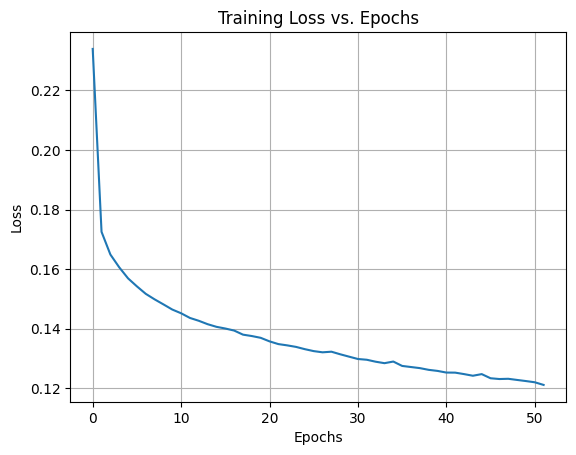

In [12]:
plt.plot(mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid()
plt.show()

### Test MLP model

We will test our model on the feature engineered test dataset. We will be using accuracy, precision, recall, F1 score, as well as a confusion matrix for evaluation.

In [13]:
# Drop irrelevant columns to match the training dataset
irrelevant_columns = ['client_id', 'creation_date', 'meter_number', 'meter_code']
X_test_prepared = X_test.drop(columns=irrelevant_columns, errors='ignore')

# Standardize the test set using the same scaler used for training
X_test_scaled = scaler_final.transform(X_test_prepared)

In [14]:
# Make predictions on the test set
y_pred = mlp.predict(X_test_scaled)

In [15]:
# Evaluate the model using various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Fraud", "Fraud"]))

Model Evaluation Metrics:
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1 Score: 0.92

Confusion Matrix:
[[24472  1063]
 [ 1039   525]]

Classification Report:
              precision    recall  f1-score   support

   Not Fraud       0.96      0.96      0.96     25535
       Fraud       0.33      0.34      0.33      1564

    accuracy                           0.92     27099
   macro avg       0.64      0.65      0.65     27099
weighted avg       0.92      0.92      0.92     27099



## RNN model

We understand that one of the limitations of the MLP model is that it does not take into account each individual invoice of a client. This results in the loss of some information regarding the sequential nature of the invoices. Hence, for the RNN model, we plan to approach this with a non-aggregated dataset. We will follow the same data cleaning as the previous dataset, but without the aggregation and SMOTE. We will then use an RNN with weight class adjustments in order to deal with the imbalanced data.

We will proceed with this flow:
1. Feature engineering for RNN
2. Preparing data for RNN
3. Model RNN
4. Evaluate RNN


### Feature engineering for RNN

The RNN model uses very different feature engineering techniques compared to the MLP model, and hence we need to handle them very differerntly. We will be looking at client first before invoice.

In [ ]:
invoice.info()

In [ ]:
client.info()

#### Client

Here, we will deal with the client dataset. 

##### creation_date breakdown

We breakdown creation_date into year, month, and day in order for our model to be able to process this feature, as it will not be able to process an object or a datetime datatype.

In [ ]:
client['creation_date'] = pd.to_datetime(client['creation_date'])
client['creation_date_year'] = client['creation_date'].dt.year
client['creation_date_month'] = client['creation_date'].dt.month
client['creation_date_day'] = client['creation_date'].dt.day

##### Drop creation_date

We will drop creation_date as we already have its derived features of year month and day.

In [ ]:
client = client.drop(columns=['creation_date'])

##### One hot encoding

We will one hot encode our non ordinal categorical features. This is because we do not want our model to assume ordinality or an order in these features, hence we have to one hot encode.

In [ ]:
non_ordinal_categorical_client = ['disrict', 'client_catg', 
                                  'region']

client = pd.get_dummies(client, columns=non_ordinal_categorical_client)

##### Label encoding

We will label the features which are categorical but have an order to them. This is to reduce the number of features we will have, and for the model to potentially learn from their ordinal nature.

In [ ]:
ordinal_categorical_client = ['creation_date_year', 'creation_date_month', 'creation_date_day']

for col in ordinal_categorical_client:
    counts = client[col].value_counts()
    print(counts)

##### final client

We will now be able to look at the final client dataset.

In [ ]:
client.info()

#### Invoice

Here, we will deal with the invoice dataset.

##### Deal with invoice_date

We will convert invoice_date to the datetime format for easier processing later down the line, as this will be the determining sequential feature that we will use for the RNN modelling.

In [ ]:
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'])

##### Scaling 

We will scale continuous variables, to ensure that all features contribute equally when it comes to the gradient descent during optimization.

In [ ]:
continuous_features_invoice = ['consumption_level_1', 'consumption_level_2',
                       'consumption_level_3', 'consumption_level_4',
                        'new_index', 'old_index']

scaler = StandardScaler()
invoice[continuous_features_invoice] = scaler.fit_transform(invoice[continuous_features_invoice])
invoice[continuous_features_invoice]

##### One hot encoding

We will similarly one hot encode the non ordinal categorical features in invoice for the same reasons as we did for client.

In [ ]:
non_ordinal_categorical_invoice = [ 'meter_status', 'meter_code', 
                            'reading_remark', 'meter_type',
                            'meter_coefficient']

invoice = pd.get_dummies(invoice, columns=non_ordinal_categorical_invoice)

##### Label encoding

We will similarly label encode the ordinal categorical features in invoice for the same reasons we did for client.

In [ ]:
ordinal_categorical_invoice = ['meter_number', 'months_number']

for col in ordinal_categorical_invoice:
    counts = invoice[col].value_counts()
    print(counts)

##### final invoice

We will now be able to look at the final invoice dataset.

In [ ]:
invoice.info()

### Preparing data for RNN

In order to prepare our dataset for RNN, we will need to firstly group our invoices by clients, in order of invoice date. We will then be able to extract their informational features. We also need to extract, for the client, their client data, as well as label data (fraud or not fraud). This is so that our RNN is able to use the sequential nature of invoices.

#### Get informational columns

We will obtain the informational features of both invoice and clients, which as the features that we want our model to learn from.

In [ ]:
# Invoice feature columns
invoice_feature_cols = invoice.columns.difference(['client_id', 'invoice_date'])

# Client feature columns
client_feature_cols = client.columns.difference(['client_id', 'fraud_status'])

In [ ]:
len(invoice_feature_cols)

In [ ]:
len(client_feature_cols)

#### Sort the dataset

We will sort our dataset by client_id and invoice_date, followed by grouping invoices by client_id. This helps us obtain the sequences of of invoices that the RNN will input.

In [ ]:
invoice = invoice.sort_values(by=['client_id', 'invoice_date'])
grouped_invoices = invoice.groupby('client_id')

#### Obtain max_length

We need to obtain the max_length of each group (max number of invoices per client), as only then are we able to apply padding to our sequences to ensure that they are all of the same length.

In [ ]:
max_length = grouped_invoices.size().max()

#### Create containers

We will create 3 containers to store the features and targets.

In [ ]:
invoice_features = []
client_features = []
targets = []


#### iterate each client

For each client, we will select informational invoice features, pad them, and add them to invoice features, then obtain their informational client features and add them to client features, followed by adding their target to the targets container.

In [ ]:
for client_id, group in grouped_invoices:
    # Extract and pad invoice features dynamically
    invoices_seq = group[invoice_feature_cols].values  # Select relevant columns
    padded_invoices = np.zeros((max_length, invoices_seq.shape[1]))
    padded_invoices[:len(invoices_seq)] = invoices_seq
    invoice_features.append(padded_invoices)
    
    # Extract client features dynamically
    client_row = client[client['client_id'] == client_id].iloc[0]
    client_feat = client_row[client_feature_cols].values
    client_feat = client_feat.astype(int)
    client_features.append(client_feat)
    
    # Append target
    targets.append(client_row['fraud_status'])

#### Pytorch dataset

We will create a custom pytorch dataset to wrap the data.

In [ ]:
class FraudDataset(Dataset):
    def __init__(self, invoice_features, client_features, targets):
        self.invoice_features = torch.tensor(invoice_features, dtype=torch.float32)
        self.client_features = torch.tensor(client_features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return {
            'invoices': self.invoice_features[idx],
            'clients': self.client_features[idx],
            'target': self.targets[idx]
        }

In [ ]:
client_features = np.array(client_features).astype(float)
invoice_features = np.array(invoice_features).astype(float)
targets = np.array(targets).astype(float)

In [ ]:
print(client_features.dtype)
print(invoice_features.dtype)
print(targets.dtype)

In [ ]:
train_dataset = FraudDataset(np.array(invoice_features), np.array(client_features), np.array(targets))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

### Training RNN model

Training the RNN model with pyTorch would require us to define a FraudRNN class. We will then set a method for forward, as well as define hyperparameters, which it will take in as input.

#### Create FraudRNN class

We will create the FraudRNN class.

In [ ]:
class FraudRNN(nn.Module):
    def __init__(self, seq_input_dim, client_input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(FraudRNN, self).__init__()
        self.lstm = nn.LSTM(input_size=seq_input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.client_dense = nn.Linear(client_input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_seq, x_client):
        _, (h_n, _) = self.lstm(x_seq)
        lstm_out = h_n[-1]
        client_out = torch.relu(self.client_dense(x_client))
        combined = torch.cat((lstm_out, client_out), dim=1)
        output = self.sigmoid(self.fc(combined))
        return output

#### Create model, criterion and optimizer.

We will then create our model with fixed hyperparameters, while setting a criterion for the loss function and an optimizer for efficient gradient upadtes.

In [ ]:
# Hyperparameters
seq_input_dim = np.array(invoice_features).shape[2]
client_input_dim = np.array(client_features).shape[1]
hidden_dim = 64
output_dim = 1
num_epochs = 10
learning_rate = 0.001
model = FraudRNN(seq_input_dim, client_input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#### Training loop

Here, we will loop the training so that the model can update its weights to reduce loss.

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_seq_batch, X_client_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_seq_batch, X_client_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

### Test RNN model


We will test our model on the feature engineered RNN test dataset. We will be using accuracy, precision, recall, F1 score, as well as a confusion matrix for evaluation.